## Gross Hueristic Score from
https://www.notion.so/asapdiscovery/Resistance-score-for-docked-ligands-4584c0bd8b0944b3a0c721f76eece48b

In [28]:
import yaml
from pathlib import Path
from asapdiscovery.data.openeye import (
    load_openeye_pdb,save_openeye_sdf,save_openeye_pdb
)
from asapdiscovery.data.plip import compute_fint_score
from asapdiscovery.modeling.modeling import split_openeye_mol
import re
import json
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Use the fintscore_params from above using plip.py
https://github.com/choderalab/asapdiscovery/commit/1ae3d5432e9845ca8cf7ae6c370ba73733da29d9

### Function to use
def compute_fint_score(
    protein: oechem.OEMol, pose: oechem.OEMol, target: TargetTags
) -> tuple[float, float]:
    
    """
    Compute the Fitness Interaction Score (FINTscore) given a dict with interactions generated by PLIP.

    Parameters
    ----------
    protein: oechem.OEMol
        Protein molecule
    pose: oechem.OEMol
        Pose molecule
    target: str
        Target name


    Returns
    ----------
    intn_score: float
        Score based purely on interactions, without penalties applied
    fint_score: float
        FINTscore which is computed as the `intn_score` with penalties applied
    """

In [2]:
local_path = Path("/Users/choderalab/asapdiscovery/temp_storage/output/")
save_path = Path("/Users/choderalab/asapdiscovery/temp_storage/output_html/")

## Go through the generated ligand-protein binding files and find mean intn and FINT scores
Get dictionary named scores with the assigned ligand number as the key and tuple of (intn, fint) as value

Save this in a json file in output_html folder

In [21]:
target_index = "ZIKV-NS2B-NS3pro"
scores = dict()
for pdb_file in local_path.glob("lig_*.pdb"):
    # Note the complex we are on
    number = re.search(r'\d+', str(pdb_file)).group()
    # Load in the complex pdb into openeye
    lig_protein = load_openeye_pdb(pdb_file)
    # Separate ligand and protein
    component_dict = split_openeye_mol(lig_protein)
    lig = component_dict["lig"]
    protein = component_dict["prot"]
    # Calculate the scores and store in the scores dict
    scores[number] = compute_fint_score(protein, lig, target_index)

2024-02-21 14:29:28,711 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-02-21 14:29:28,711 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-02-21 14:29:28,712 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-02-21 14:29:28,712 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-02-21 14:29:29,167 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /var/folders/6y/636rxrrx1glgncg45txz3vkh0000gq/T/tmpksrkl735/
2024-02-21 14:29:30,394 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-02-21 14:29:30,394 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hel

In [22]:
with open(save_path/'scores.json',"w") as file:
    json.dump(scores,file)
    file.close()

## Some of the ligands dont have any detected interactions with the protien's residues
## Visualize them with
https://github.com/choderalab/asapdiscovery/blob/main/asapdiscovery-dataviz/asapdiscovery/dataviz/scripts/pose_to_viz.py
## Inspect manually for interactions

In [ ]:
# Save all the ligands with nan scores in local_path so can use pose_to_viz to inspect
for lig in scores:
    if math.isnan(scores[lig][0]):
        lig_protein = load_openeye_pdb(local_path/f"lig_{lig}_protein.pdb")
        component_dict = split_openeye_mol(lig_protein)
        save_openeye_sdf(component_dict["lig"], local_path/f"lig_{lig}.sdf")

## Save all the different ligands into sdf files so could inspect visually

In [2]:
local_path = Path("/Users/choderalab/asapdiscovery/temp_storage/output/")
save_path = Path("/Users/choderalab/asapdiscovery/temp_storage/ligands/")
# Save all the ligands so can use pose_to_viz to inspect
for lig in range(102):
    lig_protein = load_openeye_pdb(local_path/f"lig_{str(lig)}_protein.pdb")
    component_dict = split_openeye_mol(lig_protein)
    save_openeye_sdf(component_dict["lig"], save_path/f"lig_{str(lig)}.sdf")

## Save only the protein in it's own pdf file

In [3]:
lig_protein = load_openeye_pdb(local_path/"lig_7_protein.pdb")
component_dict = split_openeye_mol(lig_protein)
save_openeye_pdb(component_dict["prot"], save_path/"zikv_protein.pdb")

PosixPath('/Users/choderalab/asapdiscovery/temp_storage/ligands/zikv_protein.pdb')

## Distribution of the FINTScores

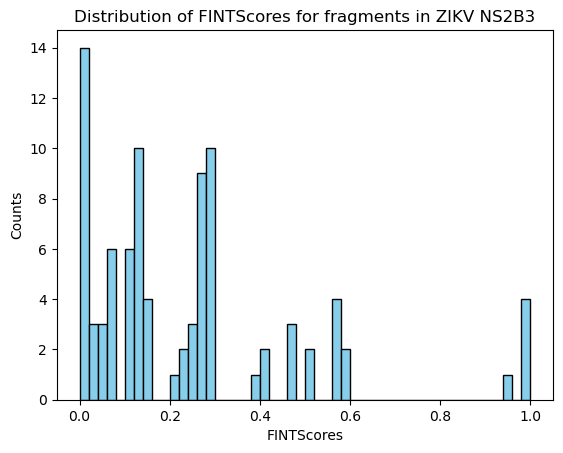

In [42]:
# Get all the FINTScores
fint_scores = []
for lig in scores:
    fint_score = scores[lig][1]
    fint_scores.append(fint_score)

# Plot the distribution of FINTScores
plt.hist(fint_scores, bins=50, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('FINTScores')
plt.ylabel('Counts')
plt.title('Distribution of FINTScores for fragments in ZIKV NS2B3')

# Save the file
plt.savefig(save_path/"fintscores.svg",format='svg', dpi=1200)

# Display the plot
plt.show()